# E13 - Analyze class homeworks


Elaborado por GRUPO 1:

- Juanita Piraban Barbosa - 201216313
- Lorena Morales Rodríguez - 202027957
- Alejandro Barinas Guio - 201628859
- Jaime Humberto Trujillo Perea - 201920366
- Alexander Zapata Galindo - 201425426

In [1]:
#pip install textblob

In [2]:
# Librerias
import pandas as pd
import numpy as np
import scipy as sp

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

#conda install -c conda-forge wordcloud
from wordcloud import WordCloud


In [3]:
# Data
data = pd.read_excel('DataSet/Consolidado_respuestas_escribir_v2.xlsx',index_col=0)
data = pd.DataFrame(data)
data.head()

,Genero,Carrera de pregrado,Sector en el que trabaja,Edad,E1 - Examples of Time Series Analysis,E4 - Panel Data,E6 - Decison Trees,E8 - Ensemble Trees Overview,E10 - REST-API,E12 - Natural Language Processing Overview
ID,,,,,,,,,,
1,M,Matemáticas,Estudio de mercados,30.0,Dentro de las diferentes aplicaciones que tien...,La principal diferencia entre las series de ti...,Los arboles de decisión son herramienta de Mac...,Al proponer un método para realizar una predic...,Durante el desarrollo de soluciones dentro de ...,La empresa kore.ai se especializa en la implem...
2,M,NaN,NaN,NaN,NaN,una serie de tiempo se enfoca en un individio ...,NaN,NaN,Un micro servicio es una parte de la arquitect...,NaN
3,M,NaN,NaN,NaN,Mercados energeticos: Tras la liberación y des...,Los datos de series de tiempo son un conjunto ...,NaN,Los metodos de ensamble nos permiten mejorar e...,Los microservicios defininen una nueva metodol...,NaN
4,M,Estadistica,Financiero,28.0,Las series de tiempo son una colección de obse...,Los datos de series de tiempo son un conjunto ...,Un árbol de decisión es una especie de mapa en...,Los métodos de ensamble de modelos o métodos c...,Los microservicios son tanto un estilo de arqu...,La función de autocompletar las palabras en Wh...
5,M,NaN,NaN,NaN,"1. Actualmente, la empresa de mascotas Laika q...",Un conjunto de datos de una serie de tiempo co...,NaN,Los modelos de ensamble consisten en mezclar l...,Los microservicios son tanto un estilo de arqu...,NaN


# Exercise 13.1

Analyze the writing patterns of each student

In [4]:
#Create the target feature (number of shares)
y = data.Edad
y.describe()

count    27.000000
mean     32.666667
std       7.426564
min      25.000000
25%      28.000000
50%      30.000000
75%      34.500000
max      53.000000
Name: Edad, dtype: float64

In [5]:
y = pd.cut(y, [0, 28, 30, 34, 53], labels=[0, 1, 2, 3])
y.value_counts()

0    8
3    7
1    7
2    5
Name: Edad, dtype: int64

In [6]:
# create document-term matrices
X1 = data['E1 - Examples of Time Series Analysis'].dropna()
X2 = data['E4 - Panel Data'].dropna()
X3 = data['E6 - Decison Trees'].dropna()
X4 = data['E8 - Ensemble Trees Overview'].dropna()
X5 = data['E10 - REST-API'].dropna()
X6 = data['E12 - Natural Language Processing Overview'].dropna()

# use CountVectorizer to create document-term matrices from X
vect = CountVectorizer()
X1_dtm = vect.fit_transform(X1)
X2_dtm = vect.fit_transform(X2)
X3_dtm = vect.fit_transform(X3)
X4_dtm = vect.fit_transform(X4)
X5_dtm = vect.fit_transform(X5)
X6_dtm = vect.fit_transform(X6)

print('Total terms',len(vect.vocabulary_))
print('Word:Time')
print(vect.vocabulary_)

Total terms 1797
Word:Time
{'la': 961, 'empresa': 592, 'kore': 960, 'ai': 61, 'se': 1499, 'especializa': 667, 'en': 594, 'implementación': 880, 'de': 458, 'asistentes': 143, 'virtuales': 1763, 'diferentes': 521, 'sectores': 1504, 'como': 317, 'lo': 1001, 'son': 1578, 'bancos': 196, 'seguros': 1512, 'empresas': 593, 'del': 471, 'sector': 1503, 'salud': 1493, 'el': 573, 'retail': 1467, 'donde': 546, 'uno': 1709, 'los': 1005, 'canales': 236, 'comunicación': 346, 'es': 641, 'por': 1292, 'medio': 1051, 'un': 1705, 'chat': 274, 'con': 352, 'asesor': 140, 'parte': 1240, 'su': 1589, 'estrategia': 687, 'mercadeo': 1061, 'tienen': 1651, 'asistente': 142, 'virtual': 1762, 'que': 1383, 'funciona': 781, 'tanto': 1617, 'página': 1380, 'web': 1779, 'muestra': 1112, 'las': 967, 'capacidades': 241, 'tener': 1636, 'soluciones': 1574, 'adaptables': 32, 'cada': 231, 'necesidad': 1138, 'https': 856, 'conversational': 404, 'what': 1781, 'is': 954, 'assistant': 154, 'función': 786, 'autocompletar': 164, 'pal

In [10]:
# rows are comments, columns are terms (aka "tokens" or "features")
print('Exercise ( Number of comments , Number of terms)')
print('E1',X1_dtm.shape)
print('E4',X2_dtm.shape)
print('E6',X3_dtm.shape)
print('E8',X4_dtm.shape)
print('E10',X5_dtm.shape)
print('E12',X6_dtm.shape)

Exercise ( Number of comments , Number of terms)
E1 (37, 1710)
E4 (38, 1082)
E6 (30, 1551)
E8 (30, 1338)
E10 (37, 1791)
E12 (28, 1797)


#### Word Cloud 

In [25]:
# features
df = vect.get_feature_names()
print(df)

['10', '175', '200', '2018', '2019', '2020', '3000', '500', '70', 'abiertas', 'abierto', 'abreviamos', 'abrir', 'accenture', 'acceso', 'acciones', 'acción', 'acentos', 'acerca', 'acercarse', 'acertadas', 'aclaraciones', 'acompañar', 'acortar', 'activa', 'activar', 'activó', 'actualiza', 'actualmente', 'acuerdo', 'ad', 'adapta', 'adaptables', 'adblock', 'además', 'adicionales', 'adicionalmente', 'adjudication', 'administradora', 'adoptado', 'adversos', 'advertencias', 'advertising', 'aetna', 'afecciones', 'afectaciones', 'afectan', 'afiliados', 'afines', 'afán', 'agencia', 'agencias', 'agendé', 'agente', 'agrega', 'agregan', 'agrupa', 'agrupación', 'agrupar', 'ahora', 'ahorrar', 'ai', 'al', 'alemania', 'alergias', 'alerta', 'alexa', 'algoritmo', 'algoritmos', 'alguna', 'algunas', 'algunos', 'algún', 'alimenta', 'aliviar', 'allá', 'alojado', 'alta', 'altamente', 'altas', 'alternativas', 'ambigüedad', 'amenaza', 'amigable', 'amplia', 'ampliación', 'ampliamente', 'ampliando', 'analistas', 

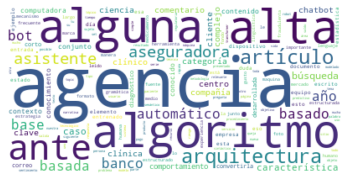

In [39]:
#Creating the text variable
text = " ".join(title for title in df)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Exercise 13.2

Evaluate the similarities of the homeworks of the students.

At a homework level, then as a student level.


# Exercise 13.3

Create a classifier to predict the gender of each student



# Exercise 13.4
Classify group members into different subgroups (minimum 3) according to a characteristic of your choice.